# Uplift Modelling Exercise: Starbucks



(Note: A good blogpost giving an oversight over general uplift strategies using the same data can be found [here](https://medium.com/datadriveninvestor/simple-machine-learning-techniques-to-improve-your-marketing-strategy-demystifying-uplift-models-dc4fb3f927a2)).

### Main learnings from this notebook

- oversampling with categorical features only works with SMOTENC
- sampling does not work within sklearn pipelines, you must use imblearns own Pipline class
- you can pass feature labels into the pipeline, but the SMOTENC sampler needs the indices of the cat features

 
### Background Information

The dataset in this exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

The main point in this implementation was to create a pipeline that oversamples the minority target class with SMOTENC (see [here](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTENC.html)) and selects an appropriate classifier. Without much further tuning the benchmark metrics could be matched / beaten.

#### Optimization Strategy

The task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).


#### How To Test Your Strategy?

The strategy can be evaluated with the `test_results` function.  There are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  Comparing quadrant I to II then gives an idea of how well the promotion strategy will work in the future. 

In [29]:
# load libraries

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.pipeline import FeatureUnion  # Pipeline imported from imblearn
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, fbeta_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# pipeline caching
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.utils import Memory

# my custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning
import custom_transformers as transform

from imblearn.over_sampling import SMOTENC # can handle cat variables
from imblearn.pipeline import Pipeline  

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
from tqdm import tqdm

more infos on why `imblearn.pipeline` [here](https://stackoverflow.com/questions/49770851/customized-transformermixin-with-data-labels-in-sklearn/49771602#49771602)

In [2]:
# load in the data
train = pd.read_csv('data/training.csv')

### EDA

In [3]:
train.sample(5)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
41560,61774,Yes,0,1,31.082784,1.432250,1,2,1,1
1582,2358,Yes,0,1,26.720966,1.172517,2,3,1,2
17533,26091,Yes,0,1,28.637154,1.259095,2,3,3,1
5458,8097,Yes,0,2,25.646738,-0.905350,1,2,4,2
21745,32374,Yes,0,2,33.861995,-1.511395,1,2,1,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [5]:
# make a copy of training set for EDA purpose

eda = train.copy()

In [6]:
# change datatypes, drop ID column

def wrangle_1_columns(df):
    df['Promotion'] = df['Promotion'].map({'Yes':1, 'No':0})
    colsToCat = ["Promotion", "V1", "V4", "V5", "V6", "V7"]
    df = cleaning.change_dtypes(df, cols_to_category=colsToCat)
    df.drop('ID', axis=1, inplace=True)

In [7]:
# call function and check results

wrangle_1_columns(eda)
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 9 columns):
Promotion    84534 non-null category
purchase     84534 non-null int64
V1           84534 non-null category
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null category
V5           84534 non-null category
V6           84534 non-null category
V7           84534 non-null category
dtypes: category(6), float64(2), int64(1)
memory usage: 2.4 MB


In [8]:
eda.describe()

,purchase,V2,V3
count,84534.000000,84534.000000,84534.000000
mean,0.012303,29.973600,0.000190
std,0.110234,5.010626,1.000485
min,0.000000,7.104007,-1.684550
25%,0.000000,26.591501,-0.905350
50%,0.000000,29.979744,-0.039572
75%,0.000000,33.344593,0.826206
max,1.000000,50.375913,1.691984


In [9]:
# check purchase distribution

display(eda['purchase'].value_counts())
print("proportion of purchases (%)", round(eda['purchase'].value_counts()[1] / len(eda) *100, 2))

0    83494
1     1040
Name: purchase, dtype: int64

proportion of purchases (%) 1.23


In [10]:
eda_grouped = eda.groupby('Promotion').mean()
eda_grouped

,purchase,V2,V3
Promotion,,,
0,0.007565,29.976876,-0.007099
1,0.017019,29.970338,0.007446


In [11]:
# calculate actual IRR

print("actual IRR: {:0.3f}%".format((eda_grouped.loc[1, 'purchase'] - eda_grouped.loc[0, 'purchase']) * 100))

actual IRR: 0.945%


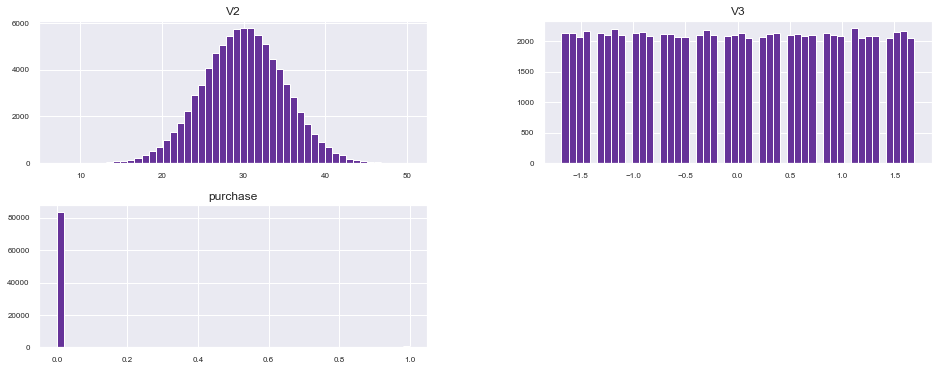

In [12]:
# look at numeric variables

EDA.plot_num_hist(eda, bins=50, figsize=(16,6))

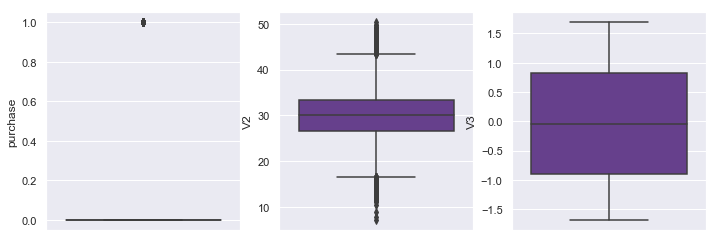

In [13]:
EDA.plot_num_box(eda, figsize=(16,4))

In [14]:
# look at categorical variables

eda.describe(include = 'category')

,Promotion,V1,V4,V5,V6,V7
count,84534,84534,84534,84534,84534,84534
unique,2,4,2,4,4,2
top,1,1,2,3,3,2
freq,42364,31631,57450,32743,21186,59317


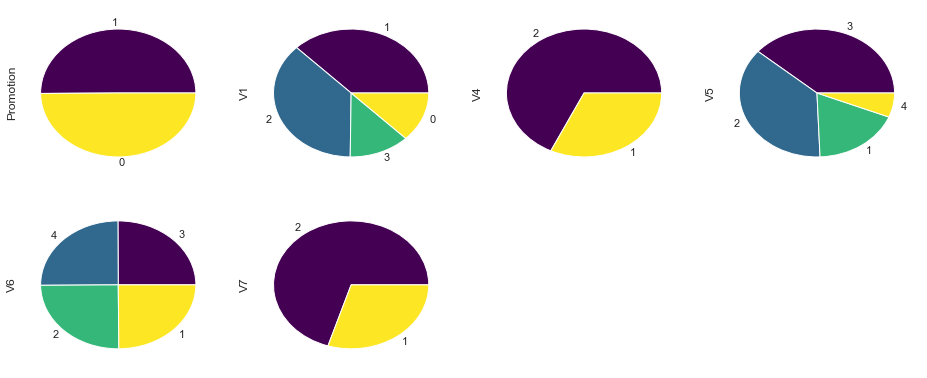

In [15]:
EDA.plot_cat_pies(eda, figsize=(16, 10))

C:\Users\r2d4\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\r2d4\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\r2d4\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\r2d4\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


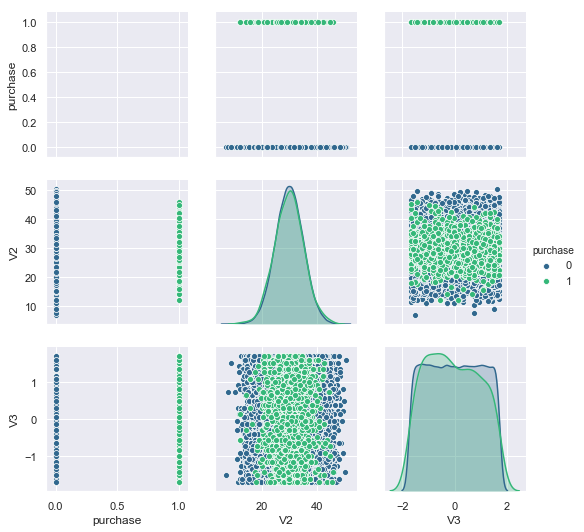

In [16]:
sns.pairplot(eda.select_dtypes(include = ['float64', 'int64']), palette='viridis', hue='purchase');

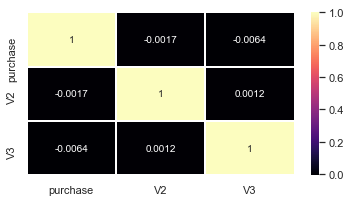

In [17]:
# check correlations for numerical columns

EDA.plot_num_corrMap(eda, figsize=(6, 3))

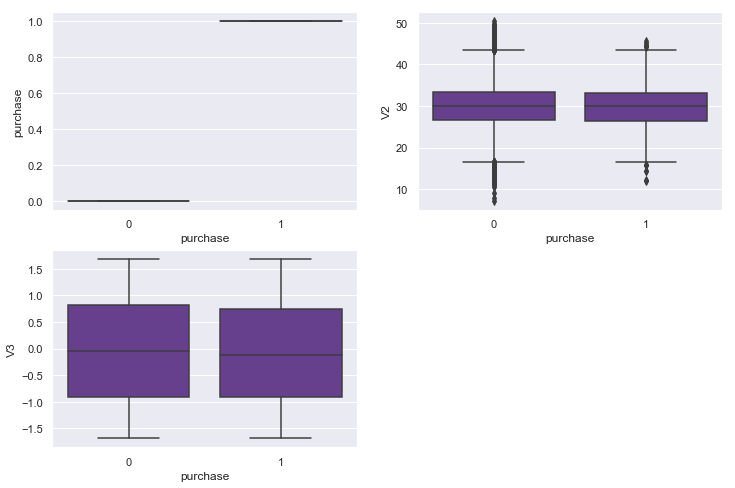

In [18]:
EDA.plot_num_corrBox(eda, 'purchase', figsize=(12, 8))

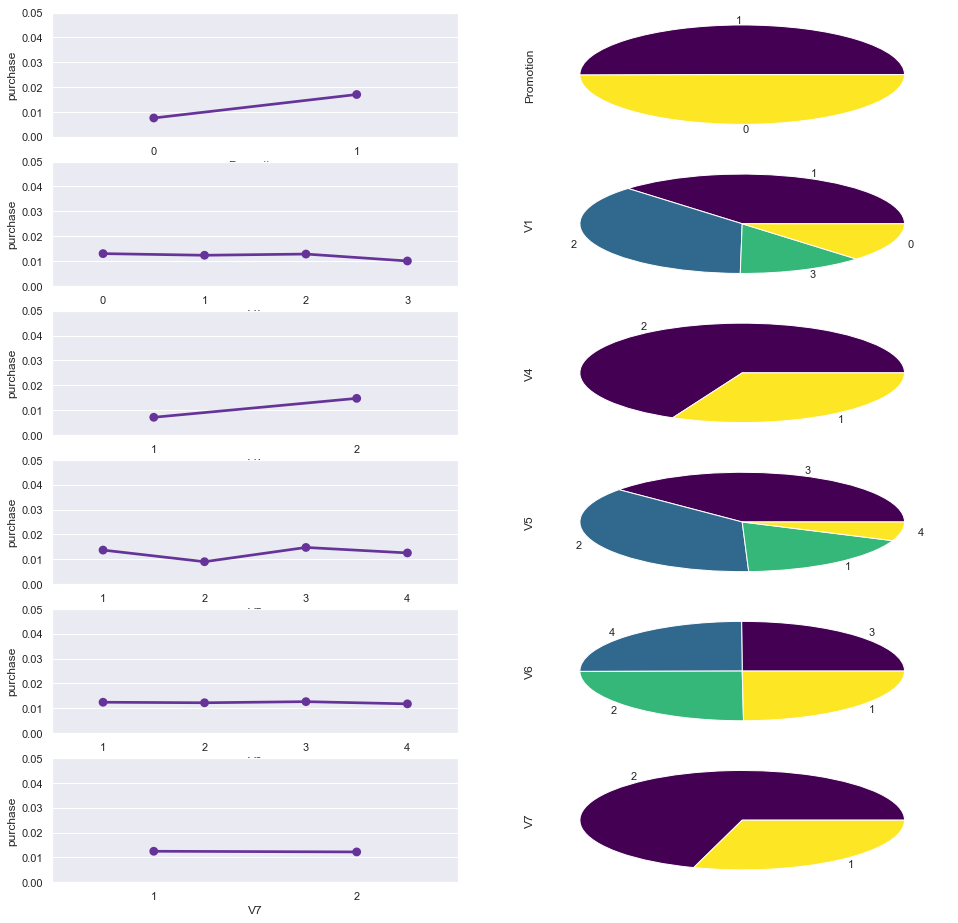

In [19]:
# check correlations for categorical columns

EDA.plot_cat_corrPoint(eda, 'purchase', figsize=(16, 16), ylim=[0,0.05])

### Calculate IRR and NIR

In [20]:
# define scoring function

def calc_IRR_NIR(df, promo_col = 'Promotion'):
    n_treat       = df.loc[df[promo_col] == 1,:].shape[0]
    n_control     = df.loc[df[promo_col] == 0,:].shape[0]
    n_treat_purch = df.loc[df[promo_col] == 1, 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_col] == 0, 'purchase'].sum()
    
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    
    return (irr, nir)

In [21]:
# call function
calc_IRR_NIR(eda)

(0.009454547819772702, -2334.5999999999995)

## Preprocess data for ML

In [22]:
# separate target variable from features

def create_Xy(df):
    """Seprate target variable from features."""

    X = df.copy()
    y = X['purchase']
    X = X.drop(['purchase', 'Promotion'], axis=1)  # Promotion is no valid input feature and has to be dropped
    
    return X, y

In [23]:
# call function an check results

X, y = create_Xy(eda)
X.shape

(84534, 7)

In [36]:
def build_pipe(X_train, y_train, clf, sampler):
    """Build a pipeline for preprocessing (including oversampling)
    and classification.
    
    ARGUMENTS:
        X_train: training features (df or array)
        y_train: training labels (df or array)
        clf: classifier (sk-learn model object)
        sampler: sampler (imblearn sampling class)
        
    RETURNS:
        full_pipe: pipeline object
    """
    
    # create temporary folder to store pipeline transformers (cache)
    cachedir = mkdtemp()
    memory = Memory(location=cachedir, verbose=1)
    
    full_pipe = Pipeline([
    ('features', FeatureUnion([

        ('cat', Pipeline([
            ('cat_select', transform.TypeSelector('category')),
            ('ohe', transform.CustomOneHotEncoder(dummy_na=True)),
        ])),

#         ('num', Pipeline([
#             ('num_select', transform.TypeSelector(np.number)),
#             ('scaling', StandardScaler()),
#         ])),
    ])),
        ('sample', sampler),
        ('clf', clf)],
        
    memory=memory)
    
    return full_pipe


In [37]:
# call the function and build the pipeline

clf = LogisticRegression()
sampler = SMOTENC(categorical_features=[0,3,4,5,6], n_jobs=-1)

full_pipe = build_pipe(X, y, clf, sampler)

In [38]:
def fit_pipe(X_train, y_train, pipe, scorer, cv=StratifiedKFold(3)):
    """Fit training data to a pipeline with GridSearchCV
    for best parameter tuning.
    
    ARGUMENTS:
        X_train: training features (df or array)
        y_train: training labels (df or array)
        pipe: pipeline (sk-learn pipeline object)
        scorer: evaluation metric for validation
        cv: type of CV, default is StratifiedKFold(3)
        
    RETURNS:
        grid: grid search object
        grid_results: dict with grid search results
    """
    parameters = {'clf' : ((LogisticRegression(solver='liblinear', class_weight='balanced')),
                          (GradientBoostingClassifier(n_estimators=200)),
                          (SGDClassifier(loss='hinge', class_weight='balanced')),
                          )}
    
    start = time.time()

    cv = GridSearchCV(pipe, param_grid=parameters, scoring=scorer, n_jobs= -1, 
                      cv=cv, error_score='raise', return_train_score=False, verbose=1)

    grid = cv.fit(X_train, y_train) 
    grid_results = grid.cv_results_

    return grid, grid_results

    # delete the temporary cache before exiting
    rmtree(cachedir)

    print('Duration: {} seconds'.format(time.time() - start))

In [39]:
# call the function

scorer = make_scorer(fbeta_score, beta=4)
cv = 3

grid, grid_results = fit_pipe(X, y, full_pipe, scorer, cv=cv)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.7min finished


________________________________________________________________________________
[Memory] Calling imblearn.pipeline._fit_transform_one...
_fit_transform_one(FeatureUnion(n_jobs=None,
       transformer_list=[('cat', Pipeline(memory=None,
     steps=[('cat_select', TypeSelector(dtype='category')), ('ohe', CustomOneHotEncoder(dummy_na=True))]))],
       transformer_weights=None), 
None,       V1         V2        V3 V4 V5 V6 V7
0      2  30.443518 -1.165083  1  1  3  2
1      3  32.159350 -0.645617  2  3  2  2
2      2  30.431659  0.133583  1  1  4  2
3      0  26.588914 -0.212728  2  1  4  2
4      3  28.044332 -0.385883  1  1  2  2
5      1  41.189415 -0.905350  2  4  4  1
6      1  40.690409  1.085939  2  2  1  2
7      2  25.971529 -1.424817  1  3  3  2
8      2  31.930423  0.393317  2  3  1  2
9      1  27.474650  0.566472  2  2  3  2
10     1  32.770916 -1.511395  2  1  4  1
11     2  32.714953 -1.424817  1  1  2  1
12     1  36.957009  0.133583  2  3  1  1
13     2  18.982690 -1.5

In [40]:
# define function to create simplified dataframe with results

def print_grid_results(grid_results, estimator_names):
    """Create simplified DataFrame with grid search results. Best suited
    for comparision of different (baseline) models.
    
        ARGUMENTS:
            grid_results: dict with results of grid search
            estimater_names: list of strings with estimator short names
            
        RETURNS:
            results: DataFrame with key metrics (test scores, time) for grid search    
    """
    
    results = pd.DataFrame(grid_results)# .sort_values('mean_test_score', ascending=False)
    results['total_time'] = results['mean_score_time'] + results['mean_fit_time']
    results = results[['param_clf', 'mean_test_score', 'std_test_score', 
                       'total_time', 'mean_fit_time', 'mean_score_time']]
    results.index = estimator_names
    
    return results

In [41]:
# call the function and display the results

results = print_grid_results(grid_results, estimator_names=['LogReg', 'GBC', 'SGD'])
results

,param_clf,mean_test_score,std_test_score,total_time,mean_fit_time,mean_score_time
LogReg,"LogisticRegression(C=1.0, class_weight='balanc...",0.191774,0.002021,132.735083,132.604904,0.130179
GBC,([DecisionTreeRegressor(criterion='friedman_ms...,0.194997,0.000260,68.777469,68.543140,0.234329
SGD,"SGDClassifier(alpha=0.0001, average=False, cla...",0.191845,0.003456,0.416568,0.291599,0.124969


In [42]:
# define a function for plotting the main results of the model comparision

def plot_grid_results(results):
    """Plot copmarision of test scores and run times for cross validated
       models.
       
       ARGUMENTS:
           results: dataframe generated with 'compare_models' function.
       """
    data = results.sort_values(by='mean_test_score', ascending=False)
    plt.figure(figsize=(18,6));
    plt.subplot(1,2,1)
    # plot the mean test scores
    sns.barplot(x='mean_test_score', y=data.index, data=data, color="rebeccapurple")
    plt.xlabel(scorer);
    plt.subplot(1,2,2)
    # Plot the mean total time
    sns.set_color_codes("pastel")
    sns.barplot(x="total_time", y=data.index, data=data,
        label="Total", color="rebeccapurple")
    # Plot the mean fit time
    sns.set_color_codes("muted")
    sns.barplot(x='mean_fit_time', y=data.index, data=data,
        label="Fit", color="yellow")
    plt.xlabel("Time for fitting (yellow) and scoring (purple)");

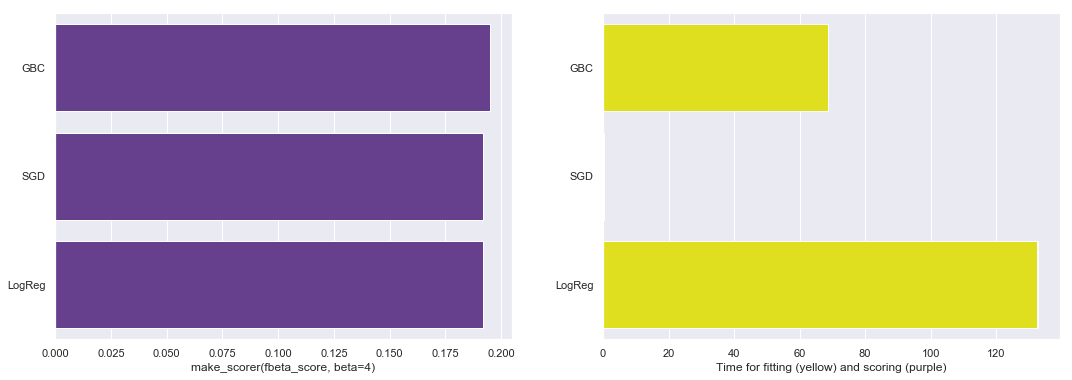

In [43]:
# call the function and display the results

plot_grid_results(results)

In [44]:
# get the best estimator

model = grid.best_estimator_

## Model evaluation

In [52]:
y_pred = model.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.57      0.73     83494
           1       0.02      0.64      0.04      1040

   micro avg       0.58      0.58      0.58     84534
   macro avg       0.51      0.61      0.38     84534
weighted avg       0.98      0.58      0.72     84534



In [53]:
print(confusion_matrix(y, y_pred))

[[47997 35497]
 [  377   663]]


In [65]:
# define a function for returning the predictions

def apply_strategy(X):
    '''
        ARGUMENTS: 
            X: Training data (Dataframe) with columns V1 - V7 only

        RETURNS:
            promotion: np.array with the values 'Yes' or 'No' 
            related to whether or not an individual should recieve 
            a promotion
    '''
    
    y_pred = list(model.predict(X))
    promotion = ['Yes' if x == 1 else 'No' for x in y_pred]
    promotion = np.array(promotion)
    
    return promotion

In [66]:
# call function and check results

promotion_strategy = apply_strategy(X)
promotion_strategy

array(['No', 'Yes', 'No', ..., 'Yes', 'Yes', 'Yes'], dtype='<U3')

In [69]:
# define evaluation functions to predict on test set and display performance in comparision to benchmark

def calc_score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    
    return (irr, nir)

def test_results(promotion_strategy):
    test_data = pd.read_csv('data/Test.csv')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    df = cleaning.change_dtypes(df, cols_to_category=['V1', 'V4', 'V5', 'V6', 'V7'])
    promos = apply_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = calc_score(score_df)
    
    print("Nice job!  See how well your strategy worked on our test data below!")
    print('\nYour irr with this strategy is {:0.4f}.'.format(irr))
    print('\nYour nir with this strategy is {:0.2f}.'.format(nir))
    print("\nWe came up with a model with an irr of {} and an nir of {} " \
    "on the test set.\n\n How did you do?".format(0.0188, 189.45))
    
    return irr, nir

In [70]:
# call function and evaluate performance

test_results(promotion_strategy)

C:\Users\r2d4\OneDrive\code\codebook\cleaning_functions.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(datatype)


Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0188.

Your nir with this strategy is 324.00.

We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018791059298456387, 324.0)

---